In [32]:
# CSCI-164 Machine Learning Project (Wine Classification)
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_type             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
None
       fixed acidity  volatile acidity  citric acid  resid

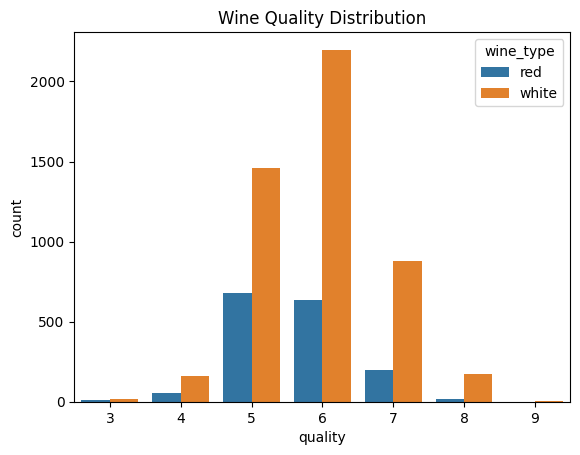

In [33]:
# Loading the datasets for red and white wine
red = pd.read_csv("/content/winequality-red.csv", sep=';')
white = pd.read_csv("/content/winequality-white.csv", sep=';')

# Add a new column to distinguish wine types
red['wine_type'] = 'red'
white['wine_type'] = 'white'

# Combine datasets
wine = pd.concat([red, white], ignore_index=True)

# Basic info (to ensure dataset is correctly loaded and check for nulls or imbalances)
print(wine.info())
print(wine.describe())
print(wine['quality'].value_counts())
print(wine.isnull().sum())

# Visualize the distribution of wine quality by wine type
sns.countplot(data=wine, x='quality', hue='wine_type')
plt.title("Wine Quality Distribution")
plt.show()

In [41]:
# Preprocessing Data
# Use 'quality' as the multi-class label
X = wine.drop(['quality', 'wine_type'], axis=1)
y = wine['quality']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# PCA on scaled data
#pca = PCA(n_components=10)
#X_train_pca = pca.fit_transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)

In [57]:
# Model training and Evaluation (baseline model)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Baseline: Scaled only
print("=== Baseline: Standard Scaled Features ===")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# With Polynomial Features
print("\n=== With Polynomial Features ===")
for name, model in models.items():
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    print(f"\n{name} with Polynomial Features Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# With PCA
#print("\n=== With PCA (10 components) ===")
#for name, model in models.items():
#     model.fit(X_train_pca, y_train)
#     y_pred = model.predict(X_test_pca)
#     print(f"\n{name} with PCA Classification Report:")
#     print(classification_report(y_test, y_pred, zero_division=0))

=== Baseline: Standard Scaled Features ===

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           3       0.02      0.50      0.03         6
           4       0.07      0.35      0.12        43
           5       0.47      0.30      0.37       402
           6       0.62      0.22      0.33       597
           7       0.27      0.26      0.26       215
           8       0.10      0.58      0.17        36
           9       0.03      1.00      0.06         1

    accuracy                           0.27      1300
   macro avg       0.22      0.46      0.19      1300
weighted avg       0.48      0.27      0.32      1300


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           3       0.33      0.17      0.22         6
           4       0.27      0.14      0.18        43
           5       0.54      0.65      0.59       402
           6       0.58      0.59      0.58       597
 

In [70]:
# Hyperparameter Tuning
# Tune number of neighbors for k-NN using Grid Search
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3)
#grid_search_knn.fit(X_train_scaled, y_train)
grid_search_knn.fit(X_train_poly, y_train)


# Output the best parameters
print("\nBest k-NN Parameters:", grid_search_knn.best_params_)


Best k-NN Parameters: {'n_neighbors': 7}



Logistic Regression Evaluation Metrics:
              precision    recall  f1-score   support

           3       0.03      0.33      0.05         6
           4       0.11      0.49      0.18        43
           5       0.50      0.45      0.47       402
           6       0.61      0.25      0.36       597
           7       0.31      0.33      0.32       215
           8       0.11      0.56      0.18        36
           9       0.33      1.00      0.50         1

    accuracy                           0.34      1300
   macro avg       0.28      0.49      0.29      1300
weighted avg       0.49      0.34      0.37      1300



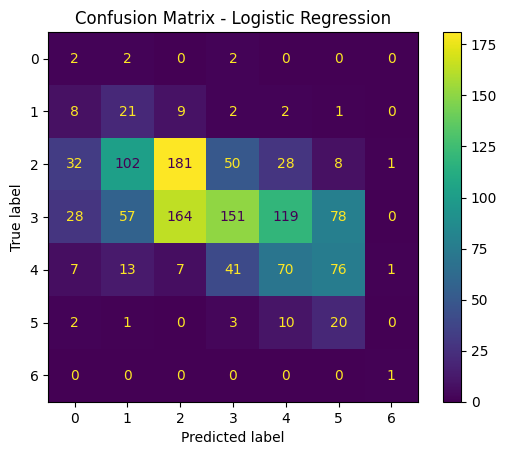

In [71]:
# Evaluation Metrics (Logistic Regression Evaluation)
final_model_logreg = models['Logistic Regression']
#y_pred_logreg = final_model_logreg.predict(X_test_scaled)
y_pred_logreg = final_model_logreg.predict(X_test_poly)

# Printing the Evaluation of the model
print("\nLogistic Regression Evaluation Metrics:")
print(classification_report(y_test, y_pred_logreg))

# Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg)
disp_logreg.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


k-NN Evaluation Metrics:
              precision    recall  f1-score   support

           3       0.50      0.17      0.25         6
           4       0.22      0.05      0.08        43
           5       0.56      0.65      0.60       402
           6       0.57      0.62      0.60       597
           7       0.51      0.38      0.44       215
           8       0.50      0.08      0.14        36
           9       0.00      0.00      0.00         1

    accuracy                           0.55      1300
   macro avg       0.41      0.28      0.30      1300
weighted avg       0.54      0.55      0.54      1300



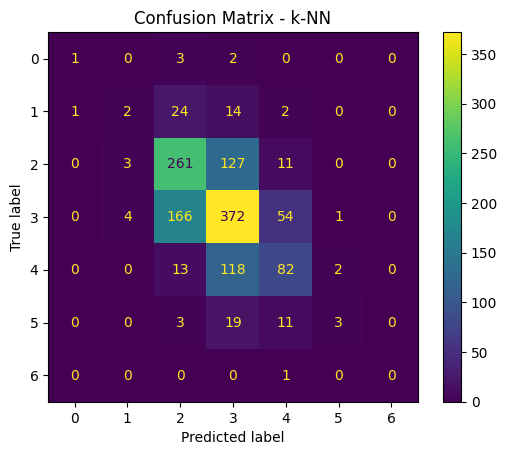

In [72]:
# Evaluation Metrics (k-NN  Evaluation)
best_knn_model = grid_search_knn.best_estimator_
#y_pred_knn = best_knn_model.predict(X_test_scaled)
y_pred_knn = best_knn_model.predict(X_test_poly)

# Printing the Evaluation of the model
print("\nk-NN Evaluation Metrics:")
print(classification_report(y_test, y_pred_knn, zero_division=0))

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot()
plt.title("Confusion Matrix - k-NN")
plt.show()